In [113]:
from harris import get_harris_corners, dist2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import scipy

In [114]:
anchor_top = Image.open("sf_left.jpg").convert("L")

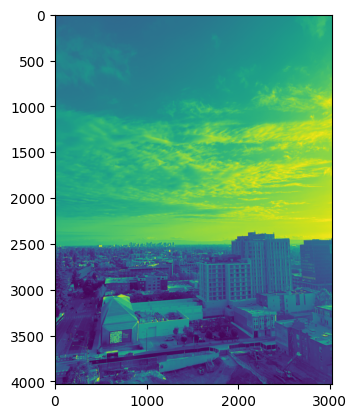

In [115]:
plt.imshow(anchor_top)

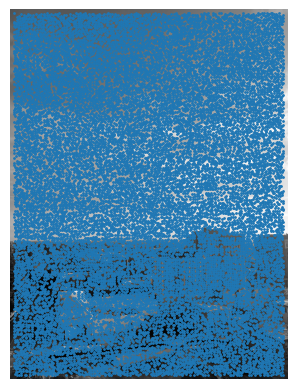

In [116]:
h, coords = get_harris_corners(np.array(anchor_top) / 255, edge_discard=40, min_distance=10)
plt.imshow(anchor_top, cmap="grey")
plt.scatter(coords[1], coords[0], s=1)
plt.axis('off')
plt.savefig("corners.jpg", bbox_inches='tight')

In [117]:
def perform_anms(coords, h_matrix, k=10, return_minr=False):
    confidences = h_matrix[*coords]
    corners = np.array([confidences, *coords])
    corners = corners[:, np.argsort(corners[0])[::-1]].T

    r = []
    dist_matrix = dist2(corners[:, 1:], corners[:, 1:])
    for i in range(corners.shape[0]):
        candidates = corners[corners[:, 0] > corners[i, 0] / 0.9]
        if candidates.shape[0] > 0:
            dists = dist_matrix[i, :candidates.shape[0]]
            r.append(min(dists))        
        else:
            r.append(1e9)
    anms_corners = corners[np.argsort(r), :][:k]
    min_r = sorted(np.array(r) ** 0.5, reverse=True)[k - 1]
    # remove h
    if return_minr:
        return anms_corners[:, 1:], min_r
    return anms_corners[:, 1:]
    

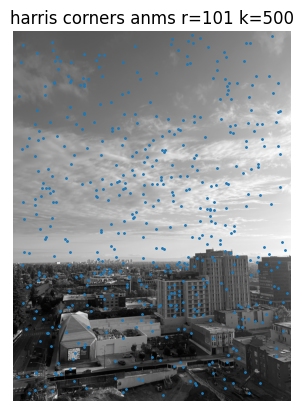

In [118]:
anms_corners, min_r = perform_anms(coords, h, k=500, return_minr=True)
plt.imshow(anchor_top, cmap="grey")
plt.scatter(anms_corners[:, 1], anms_corners[:, 0], s=1)
plt.axis('off')
plt.title(f"harris corners anms r={int(min_r)} k=500")
plt.savefig("corners_anms.jpg", bbox_inches='tight')

In [119]:
from PIL import ImageFilter
def crop_downsample(img, y, x, normalize=True, show=False):
    # get 40 by 40
    # y x middle will be shifed to 20,20 not middle
    blur_img = img.filter(ImageFilter.GaussianBlur(2))
    np_img = np.array(img)
    blur_img = np.array(blur_img)
    patches: list[np.ndarray] = []
    crops = []
    unblurred_crops = []
    for y, x in zip(y, x):
        crop = blur_img[y - 20:y + 20, x - 20:x + 20]
        if show:
            crops.append(crop)
            unblurred_crops.append(np_img[y - 20:y + 20, x - 20:x + 20])
        sub_sampled = crop[::5, ::5]
        patches.append(sub_sampled)
    
    
    def arrange_plt(patches, cols=5):
        h, w = patches[0].shape
        patches = patches[:25]
        patches = np.array(patches).reshape(-1, cols, h, w)
        patches = np.einsum("r c h w -> r h c w", patches)
        patches = patches.reshape(-1, cols * w)
        return patches
    
    if show:
        unblurred_crops = arrange_plt(unblurred_crops)
        plt.imshow(unblurred_crops, cmap="grey")
        plt.axis("off")
        plt.title("40x40 patches")
        plt.savefig("patches40x40.jpg", bbox_inches='tight')
        plt.show()
        crops = arrange_plt(crops)
        plt.imshow(crops, cmap="grey")
        plt.axis("off")
        plt.title("Blurred 40x40 patches")
        plt.savefig("blurred40x40.jpg", bbox_inches='tight')
        plt.show()
        show_patches = arrange_plt(patches)
        plt.imshow(show_patches, cmap="grey")
        plt.axis("off")
        plt.title("8x8 features")
        plt.savefig("features8x8.jpg", bbox_inches='tight')
        plt.show()
    
    if normalize:
        new_patches = []
        for patch in patches:
            std = patch.std()
            mean = patch.mean()
            new_patches.append((patch - mean) / std)
        patches = new_patches
    return np.array(patches)

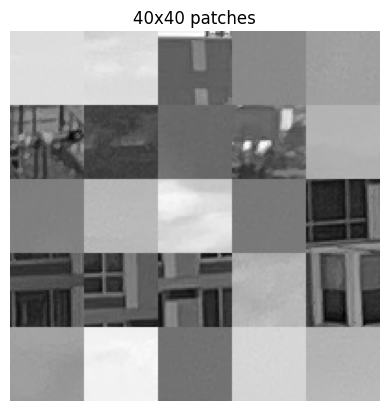

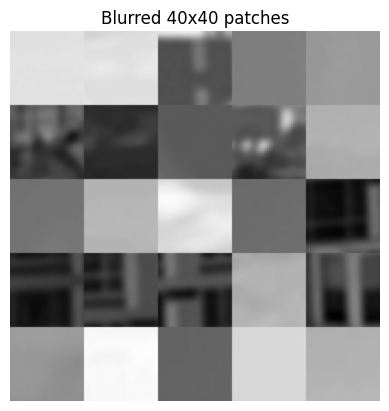

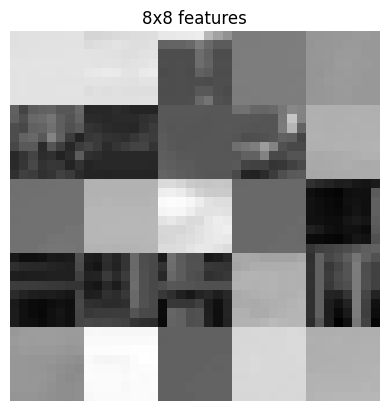

In [120]:
patches = crop_downsample(anchor_top, anms_corners[:,0].astype(int), anms_corners[:, 1].astype(int), show=True)

In [121]:
def match_features(crops_left, crops_right):
    thresh = 0.5
    crops_left = crops_left.reshape((crops_left.shape[0], -1))
    crops_right = crops_right.reshape((crops_right.shape[0], -1))
    nn = NearestNeighbors(n_neighbors=2)
    nn.fit(crops_right)
    dist, ind = nn.kneighbors(crops_left, n_neighbors=2, return_distance=True)
    error = (dist[:, 0] / dist[:, 1]) ** 2
    return np.argwhere(error < thresh).squeeze(), ind[error < thresh][:,0]

In [122]:
left, right = match_features(*([np.array(patches)] * 2))

In [123]:
left, right

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [124]:
def match_points(im_left, im_right, k=500):
    h_left, coords_left = get_harris_corners(np.array(im_left) / 255, edge_discard=200, min_distance=10)
    h_right, coords_right = get_harris_corners(np.array(im_right) / 255, edge_discard=200, min_distance=10)
    points_left = perform_anms(coords_left, h_left, k=k)
    points_right = perform_anms(coords_right, h_right, k=k)
    crops_left = crop_downsample(im_left, *points_left.T.astype(int))
    crops_right = crop_downsample(im_right, *points_right.T.astype(int))
    left_ind, right_ind = match_features(crops_left, crops_right)
    return points_left[left_ind], points_right[right_ind]

def debug_matching(im_left, im_right, points_left, points_right):
    crops_left = crop_downsample(im_left, *points_left.T.astype(int), show=True)
    crops_right = crop_downsample(im_right, *points_right.T.astype(int), show=True)
    left_ind, right_ind = match_features(crops_left, crops_right)
    return points_left[left_ind], points_right[right_ind]



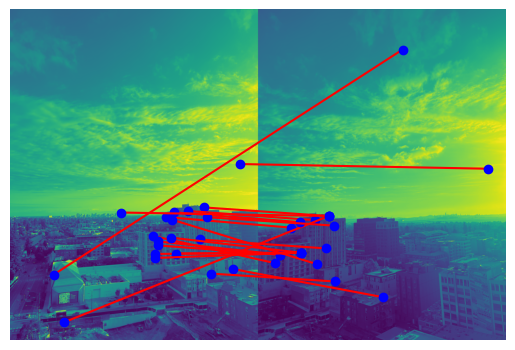

In [125]:
anchor_top = Image.open("sf_left.jpg").convert("L")
anchor_bot = Image.open("sf_right.jpg").convert("L")

# with open("sf_left_sf_right.json") as f:
#     matches = json.load(f)
#     points_left = np.array(matches["im1Points"])[:4,::-1]
#     points_right = np.array(matches["im2Points"])[:4,::-1]

# top, bot = debug_matching(anchor_top, anchor_bot, points_left, points_right)
top, bot = match_points(anchor_top, anchor_bot)
plt.imshow(np.concatenate([anchor_top, anchor_bot], axis=1))
for i in range(top.shape[0]):
    plt.plot([top[i, 1], bot[i, 1] + anchor_top.width], [top[i, 0], bot[i, 0]], 'r-')
    plt.plot(top[i, 1], top[i, 0], 'bo')
    plt.plot(bot[i, 1] + anchor_top.width, bot[i, 0], 'bo')
plt.axis("off")
plt.savefig("matches.jpg", bbox_inches='tight')


In [126]:
def computeA_slice(im1_pt, im2_pt):
    # this is for mapping im2 onto im1
    x, y = im2_pt
    u, v = im1_pt
    return np.array([
        [x, y, 1, 0, 0, 0, -u*x, -u*y],
        [0, 0, 0, x, y, 1, -v*x, -v*y]
    ])

def computeH(im1_pts, im2_pts, verbose=False):
    # compute the homography H that maps points from image 2 to image 1
    slices = []
    for i in range(im1_pts.shape[0]):
        A_slice = computeA_slice(im1_pts[i], im2_pts[i])
        slices.append(A_slice)
    A = np.concatenate(slices)
    if verbose:
        print("A shape:", A.shape)
        print("A:", A)
    
    b = im1_pts.flatten()
    if verbose:
        print("b shape:", b.shape)
        print("b:", b)

    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.concatenate((H, [1])).reshape(3, 3)

    return H

def ransac_loop(points_left, points_right, k = 10, eps=1):
    
    inlier_set_left = None
    inlier_set_right = None
    for i in range(k):
        # select 4 feature pairs at random
        points_ind = np.random.randint(0, points_left.shape[0], size=(4,))
        subset_left = points_left[points_ind]
        subset_right = points_right[points_ind]
        # compute homography
        H = computeH(subset_left, subset_right)
        # compute inliers where dist p Hp_right < eps
        # transform points on the right
        padded_points_right = np.pad(points_right, ((0, 0), (0, 1)), constant_values=1)
        right_projected = np.einsum("n p, o p -> n o", padded_points_right, H)
        # divide z and remove z
        right_projected = right_projected[:, :2] / right_projected[:, 2:]
        error = np.linalg.norm(points_left - right_projected, axis=-1)
        filter = error < eps
        new_inliers_left = points_left[filter]
        new_inliers_right = points_right[filter]
        # keep the largest set of inliers
        if inlier_set_left is None or new_inliers_left.shape[0] > inlier_set_left.shape[0]:
            inlier_set_left = new_inliers_left
            inlier_set_right = new_inliers_right
    # Recompute H with the full set of inliers
    return computeH(inlier_set_left, inlier_set_right), inlier_set_left, inlier_set_right

In [127]:
H, inliers_top, inliers_bot = ransac_loop(top, bot, eps=10, k=900)

C:\Users\gui3di4\AppData\Local\Temp\ipykernel_38632\2225736812.py:47: RuntimeWarning: divide by zero encountered in divide
  right_projected = right_projected[:, :2] / right_projected[:, 2:]


In [128]:
H

array([[ 9.24843960e-01, -3.20459828e-01,  1.14407858e+02],
       [ 6.41296041e-02,  5.84748759e-01,  1.43068620e+03],
       [ 8.84018182e-06, -1.43476140e-04,  1.00000000e+00]])

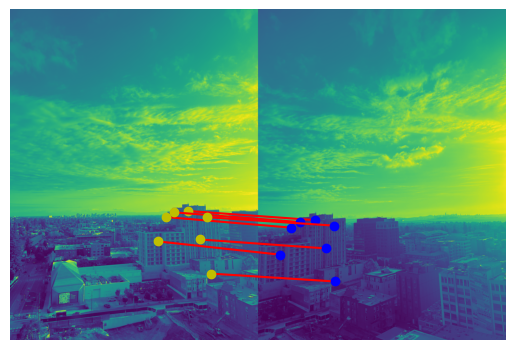

In [129]:
plt.imshow(np.concatenate([anchor_top, anchor_bot], axis=1))
padded_points_bot = np.pad(inliers_bot, ((0,0),(0,1)), constant_values=1)
bot_projected = np.einsum("n p, o p -> n o", padded_points_bot, H)
bot_projected = bot_projected[:, :2] / bot_projected[:, 2:]
for i in range(inliers_bot.shape[0]):
    plt.plot([inliers_top[i, 1], inliers_bot[i, 1] + anchor_bot.width], [inliers_top[i, 0], inliers_bot[i, 0]], 'r-')
    plt.plot(inliers_top[i, 1], inliers_top[i, 0], 'yo')
    plt.plot(inliers_bot[i, 1] + anchor_top.width, inliers_bot[i, 0], 'bo')
plt.axis('off')
plt.savefig("matches_ransac.jpg", bbox_inches='tight')

In [130]:
def warpImageNearestNeighbor(im, H):
    H_inv = np.linalg.inv(H)
    h, w, _ = im.shape
    # find the coords of the transform.
    # H @ 0, 0 will give the coords of the top left of the photo relative to the base image
    # If we want to retrieve an array with the image we can paste into the base image we need to find the x, y offset
    # of the top left which might not be 0, 0
    # min x and min y of the corners will give us the offset of the full image including black space and enough to fit the image
    
    # apply H to the corners of the image
    corners = np.array([[0, 0, 1], [h, 0, 1], [0, w, 1], [h, w, 1]])
    proj_corners = np.einsum("o i, n i -> n o", H, corners)
    proj_corners /= proj_corners[:, 2:3]
    proj_corners = proj_corners.T
    print(proj_corners.T.astype(int))
    # upper left min x, min y
    min_y, min_x, _ = np.floor(np.min(proj_corners, axis=1)).astype(int)
    max_y, max_x, _ = np.ceil(np.max(proj_corners, axis=1)).astype(int)
    print(min_y, min_x, max_y, max_x)
    
    # generate mesh grid
    yxz = np.array(np.meshgrid(np.arange(int(min_y), int(max_y)), np.arange(int(min_x), int(max_x)), [1], indexing='ij'))
    base_points = np.einsum("p y x z, i p -> i y x", yxz, H_inv)
    # output_shape = (int(max_y)-int(min_y), int(max_x)-int(min_x), 1)
    # y = np.broadcast_to(np.arange(int(min_y), int(max_y)).reshape(-1, 1, 1), output_shape)
    # x = np.broadcast_to(np.arange(int(min_x), int(max_x)).reshape(1, -1, 1), output_shape)
    # z = np.ones((int(max_y)-int(min_y), int(max_x)-int(min_x), 1))
    # yxz = np.dstack((y, x, z))
    # base_points = np.einsum("y x p, i p -> i y x", yxz, H_inv)
    base_points /= base_points[2]
    nn_points = np.rint(base_points[:2]).astype(int)
    
    # remove z axis
    mask = np.all(nn_points >= 0, axis=0)
    mask &= nn_points[0] < h
    mask &= nn_points[1] < w
    
    # zero index the mask to prevent out of bounds
    nn_points[~np.stack((mask, mask))] = 0
    
    # cast all points!
    return im[*nn_points] * mask[:,:,None], mask, np.array([int(min_y), int(min_x)])

In [131]:
def auto_mosaic(im1, im2, merge=True, save_mask=False):
    # H = computeH(points_left, points_right)
    points_left, points_right = match_points(im1.convert("L"), im2.convert("L"))
    im1 = np.array(im1) / 255
    im2 = np.array(im2) / 255
    H, inliers_top, inliers_bot = ransac_loop(points_left, points_right, eps=10, k=900)

    im2_w, mask, warp_offset = warpImageNearestNeighbor(im2, H)
    h1, w1, _ = im1.shape
    h2, w2, _ = im2_w.shape
    min_y = min(0, warp_offset[0])
    min_x = min(0, warp_offset[1])
    
    # offset from im1 to canvas 00 and im2 to canvas 00
    offset1 = - np.array([min_y, min_x])
    offset2 = offset1 + warp_offset
    
    max_y = max(h1, warp_offset[0] + h2)
    max_x = max(w1, warp_offset[1] + w2)
    canvas = np.zeros((max_y - min_y, max_x - min_x, 3))
    if merge:
        canvas_mask1 = np.ones((max_y - min_y, max_x - min_x), dtype=bool)
        canvas_mask2 = np.ones((max_y - min_y, max_x - min_x), dtype=bool)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.figure()
        
        canvas_mask1[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] *= (1 - mask).astype(bool)
        canvas_mask2[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] *= False
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.figure()
        
        negative_mask = ~canvas_mask1 & ~canvas_mask2
        canvas_mask1[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] |= True
        canvas_mask2[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] |= mask.astype(bool)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.savefig("base_mask.jpg", bbox_inches='tight')
            plt.figure()
            


        # find dist to bg which is the opposite photo
        mask1 = scipy.ndimage.distance_transform_edt(canvas_mask1)
        if save_mask:
            plt.imshow(mask1)
            plt.savefig("bw_dist.jpg", bbox_inches='tight')
            plt.figure()
        mask2 = scipy.ndimage.distance_transform_edt(canvas_mask2)

        if save_mask:
            plt.imshow(negative_mask)
            plt.savefig("negative_mask.jpg", bbox_inches='tight')
            plt.figure()
            

        # apply normalization to get weighted average by distance
        canvas_mask1 = canvas_mask1 * ~negative_mask + negative_mask * mask1 / (mask1 + mask2)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.savefig("full_mask.jpg", bbox_inches='tight')
            plt.figure()
        
        
        canvas_mask2 = canvas_mask2 * ~negative_mask + negative_mask * (1 - canvas_mask1)
        if save_mask:
            plt.imshow(canvas_mask2)
            plt.figure()

        canvas[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] = im1 * canvas_mask1[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1][:, :, None]
        canvas[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] += im2_w * canvas_mask2[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2][:, :, None]
    else:
        canvas[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] = im1
        canvas[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2][mask[:, :]] = im2_w[mask[:, :]]
    return canvas

In [132]:
def to_PIL(image: np.ndarray):
    assert image.dtype == float
    return Image.fromarray((image * 255).astype(np.uint8))

C:\Users\gui3di4\AppData\Local\Temp\ipykernel_38632\2225736812.py:47: RuntimeWarning: divide by zero encountered in divide
  right_projected = right_projected[:, :2] / right_projected[:, 2:]


[[  114  1430     1]
 [ 3711  1631     1]
 [-1509  5650     1]
 [ 4776  5745     1]]
-1510 1430 4777 5746


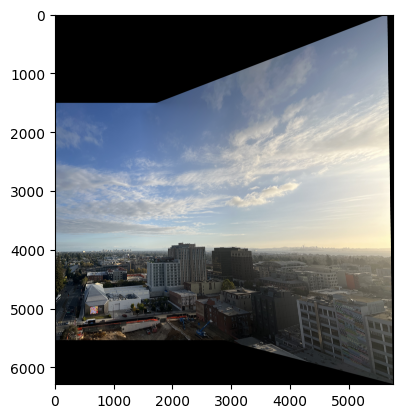

In [133]:
anchor_top_color = Image.open("sf_left.jpg")
anchor_bot_color = Image.open("sf_right.jpg")

canvas = auto_mosaic(anchor_top_color, anchor_bot_color)
to_PIL(canvas).save("sf_auto_mosaic.jpg")
plt.imshow(canvas)

[[  437  1910     1]
 [ 3944  2096     1]
 [-3062  7940     1]
 [ 7555 10171     1]]
-3063 1910 7556 10172


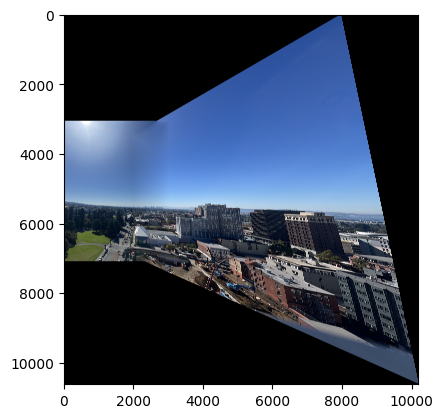

In [134]:
anchor_top_color = Image.open("oakland_right.jpg")
anchor_bot_color = Image.open("oakland_left.jpg")

canvas = auto_mosaic(anchor_top_color, anchor_bot_color)
to_PIL(canvas).save("oakland_auto_mosaic.jpg")
plt.imshow(canvas)

[[  167  1491     1]
 [ 3726  1567     1]
 [-1058  5451     1]
 [ 4840  5598     1]]
-1059 1491 4841 5599


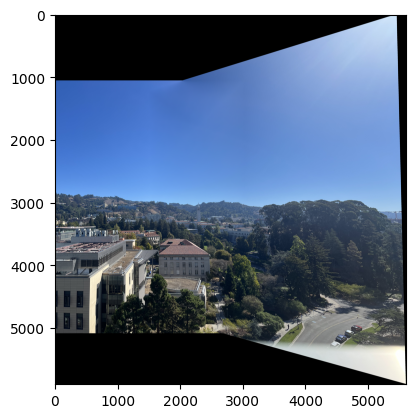

In [135]:
anchor_top_color = Image.open("camp_left.jpg")
anchor_bot_color = Image.open("camp_right.jpg")

canvas = auto_mosaic(anchor_top_color, anchor_bot_color)
to_PIL(canvas).save("camp_auto_mosaic.jpg")
plt.imshow(canvas)